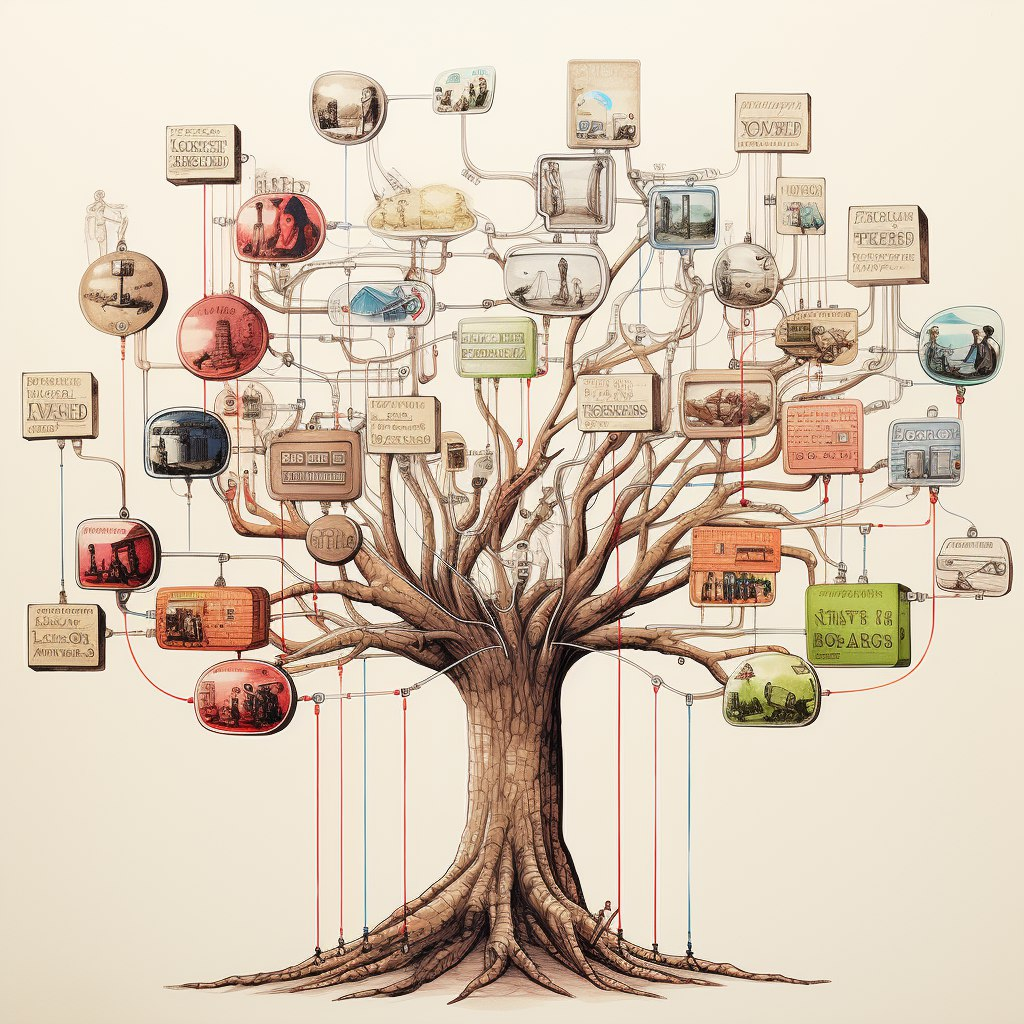
<center> Изображение сгенерировано Midjourney по запросу "решающее дерево распознает голоса людей"

# Модель определения пола по голосу на алгоритме решающего дерева

Для решения данной задачи мы нашли готовый датасет, в котором все преобразования аудиоинформации в числовой табличный формат уже произведены. Оригинальная страница датасета на Kaggle с подробным описанием задачи находится [здесь](https://www.kaggle.com/datasets/primaryobjects/voicegender).

Набор данных состоит из 3 168 записанных образцов голоса мужчин и женщин. Образцы предварительно обрабатываются с помощью акустического анализа на языке программирования R с использованием специальных библиотек в диапазоне частот 0-280 Гц (диапазон человеческого голоса). Если вкратце, в результате обработки звук на аудиозаписи оцифровывается и преобразуется в числовую последовательность частот, из которой извлекаются различные статистические характеристики, например средняя частота, с которой говорит спикер на аудиозаписи, или частота с наибольшей энергией и так далее. В столбцах таблицы содержатся статические характеристики для каждой из аудиозаписей, вычисленные на основе акустических свойств.

## Обзор данных

Cписок столбцов и их краткое описание.

|Feature|Description|Feature|Description|
|-|-|-|-|
|**meanfreq**|средняя частота голоса спикера (в кГц)|**centroid**|частотный центроид|
|**sd**|стандартное отклонение частоты (в кГц)|**peakf**|пиковая частота (частота с наибольшей энергией)|
|**median**|медианная частота (в кГц)|**meanfun**|среднее значение основной частоты, измеренной по акустическому сигналу|
|**Q25**|первый квартиль частоты (25-я квантиль) (в кГц)|**minfun**|минимальное значение основной частоты, измеренной по акустическому сигналу|
|**Q75**|третий квартиль частоты (75-я квантиль) (в кГц)|**maxfun**|максимальное значение основной частоты, измеренной по акустическому сигналу|
|**IQR**|межквартильный размах (Q75-Q25) (в кГц)|**meandom**|среднее значение доминирующей частоты, измеренной по акустическому сигналу|
|**skew**|асимметрия распределения частот|**mindom**|минимальное значение доминирующей частоты, измеренной по акустическому сигналу|
|**kurt**|эксцесс распределения частот|**maxdom**|максимальное значение доминирующей частоты, измеренной по акустическому сигналу|
|**sp.ent**|спектральная энтропия|**dfrange**|диапазон доминирующей частоты, измеренный по акустическому сигналу|
|**sfm**|спектральная равномерность|**modindx**|индекс модуляции|
|**ode**|модальная частота (наиболее популярная частота голоса)|**label**|целевой признак — метка класса: male (голос принадлежит мужчине) или female (голос принадлежит женщине)|

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

Итак, приступаем к работе. Прочитаем наши данные:

In [2]:
voice_data = pd.read_csv('data/voice_gender.zip')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


Посмотрим на типизацию признаков:

In [3]:
voice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

Итак, все признаки, за исключением целевого, кодируются числовым форматом. Типизация целевой переменной не имеет значения для моделей машинного обучения в библиотеке sklearn, поэтому кодирование категориальных признаков нам не потребуется.

Заодно проверим данные на наличие пропусков:

In [4]:
voice_data.isnull().sum().sum()

0

Общее количество пропусков в датасете равно 0. Значит, обработка пропущенных значений нам не потребуется.

Ранг матрицы: 18
Определитель: 0.0


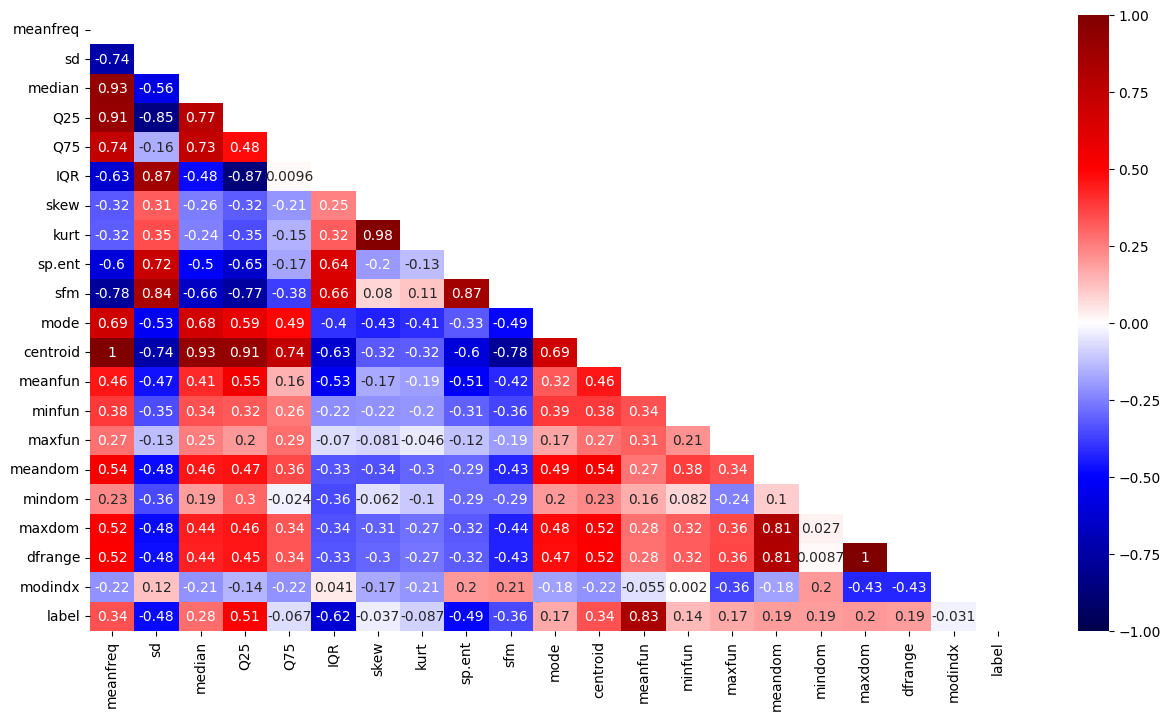

In [5]:
# Скопируем датасет
df = voice_data.copy()
# Закодируем цеоевую переменную, чтобы
# оценить корреляцию с ней признаков
df['label'] = df['label'].apply(lambda x: ['male', 'female'].index(x))

# Матрица корреляций
data_corr = df.corr()
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(data_corr) # Треугольная маска
fig, axes = plt.subplots(figsize=(15, 8))
# Тепловая карта
sns.heatmap(
    data_corr, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);

# Параметры матрицы
print('Ранг матрицы:', np.linalg.matrix_rank(data_corr))
print('Определитель:', np.round(np.linalg.det(data_corr), 6))

Т.к. определитель матрицы корреляции равен нулю (вырожденный случай), модель классической линейной регрессии в нашем случае мало подходит, если мы желаем произвести обучение на всех фичах. В ином случае нам необходимо было бы удалить 3 высоко скореллированных признака, чтобы привести число столбцов в таблице корреляции в соответствие с рангом матрицы.

Перейдём к формированию обучающей и тестовой выборок. Разделим датасет на две части в соотношении 80/20:

In [6]:
X = voice_data.drop('label', axis=1)
y = voice_data['label']

# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2534, 20)
Test shape: (634, 20)


Дополнительная предобработка данных нам не потребуется, поэтому мы можем смело перейти к построению моделей. Для моделирования мы, конечно же, будем использовать модели «древесного» типа.

## Моделирование

Начнём с решающего пня. Создадим модель дерева решений максимальной глубины 1. В качестве критерия информативности возьмем энтропию Шеннона. Обучим модель на тренировочной выборке и визуализируем ее в виде графа.

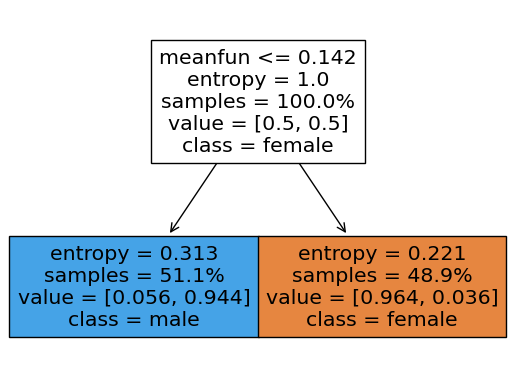

In [7]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)

# Обучение
dt.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
    class_names=dt.classes_ #имена классов
);

Решающее правило в корневой вершине построено на основе фактора meanfun (средняя основная частота в акустическом спектре). Оптимальное пороговое значение для этого фактора: 0,142. Как видим, данному условию удовлетворяют 51,1% наблюдений.

In [8]:
# Предсказание
y_test_pred = dt.predict(X_test)
# Вывод метрики
print('Accuracy: ', end='')
print(round(metrics.accuracy_score(y_test, y_test_pred), 4))

Accuracy: 0.9558


У нас уже получилась довольно качественная модель, судя по метрике. Но мы пойдем дальше.

Увеличим глубину дерева. Создадим дерево решений с максимальной глубиной 2. В качестве критерия информативности также возьмем энтропию Шеннона. Обучим модель на тренировочной выборке и визуализируем ее в виде графа.

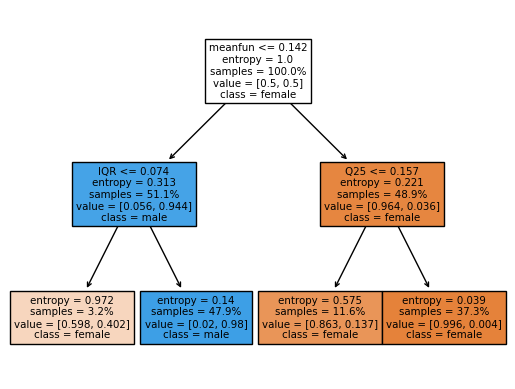

In [9]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt_2 = tree.DecisionTreeClassifier(
    max_depth=2, #глубина
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
dt_2.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt_2, #дерево решений 
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
    class_names=dt_2.classes_ #имена классов
);

Здесь решающие правила вершинах глубины 1 построены на основе факторов IQR (межквартильный размах частот) и Q25 (первый квартиль частоты). Любопытно, что ни в одном из лисьтев правой ветки класс male не имеет значимую долю.

In [10]:
# Предсказание
y_test_pred_2 = dt_2.predict(X_test)
# Вывод метрики
print('Accuracy: ', end='')
print(round(metrics.accuracy_score(y_test, y_test_pred_2), 4))

Accuracy: 0.9621


Ожидаемо, что результат улучшился лишь ненамного.

Дадим же дереву решений полную свободу. Создадим дерево решений, не ограничивая его максимальную глубину.

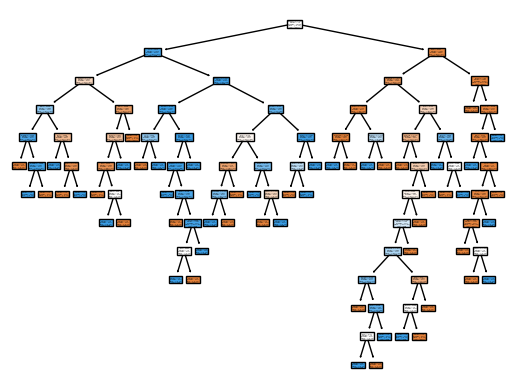

In [11]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt_3 = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt_3.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt_3, #дерево решений 
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
    class_names=dt_3.classes_ #имена классов
);

Дерево решений израсходовало запас беспорядка в данных и разложило все по полочкам. Accuracy здесь, разумеется, 1.

In [12]:
# Выведем характеристики дерева
print(
    f'Глубина дерева: {dt_3.get_depth()}',
    f'Число листьев:  {dt_3.get_n_leaves()}',
    sep='\n'
)

Глубина дерева: 12
Число листьев:  54


In [13]:
# Предсказание
y_train_pred_3 = dt_3.predict(X_train)
y_test_pred_3 = dt_3.predict(X_test)
# Вывод метрики для треннировочной выборки
print('Accuracy (train): ', end='')
print(round(metrics.accuracy_score(y_train, y_train_pred_3), 4))
# Вывод метрики для тестовой выборки
print('Accuracy (test): ', end='')
print(round(metrics.accuracy_score(y_test, y_test_pred_3), 4))

Accuracy (train): 1.0
Accuracy (test): 0.9732


Метрика на тестовой выборке стала лучше на одну сотую - и это ценой полного переобучения дерева, что лишь еще раз напоминает нам о нецелесообразности подобных решений: времени они могут у нас забрать уйму, но незначительно отразиться на конечном результате. Предельная полезность новой единицы глубины дерева доволно быстро сходит на нет.

Попробуем же найти оптимальные внешние параметры модели дерева решений для поставленной задачи. Воспользуемся классическим методом подбора гиперпараметров — перебором на сетке с кросс-валидацией (Grid SearchCV).

Зададим сетку параметров:

In [14]:
# Задаём сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'], #критерий информативности
    'max_depth': [4, 5, 6, 7, 8, 9, 10], #максимальная глубина дерева
    'min_samples_split': [3, 4, 5, 10] #минимальное количество объектов, необходимое для сплита
}

В качестве кросс-валидатора будем использовать k-fold-валидатор со стратификацией (StratifiedKFold):

In [15]:
# Задаём метод кросс-валидации
cv = model_selection.StratifiedKFold(n_splits=5)

С помощью Grid SearchCV из модуля model_selection библиотеки sklearn переберем гиперпараметры дерева решений из приведенной сетки на обучающей выборке и найдем оптимальные.

In [16]:
%%time
# Задаём сетку параметров
grid_search_dt = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=0), 
    param_grid=param_grid, 
    cv=cv, 
    n_jobs=-1,
    scoring='accuracy'
)
grid_search_dt.fit(X_train, y_train)
print(f'Best Params: {grid_search_dt.best_params_}')
print(f'Best cv-score: {grid_search_dt.best_score_:.4f}')

Best Params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}
Best cv-score: 0.9657
Wall time: 2.81 s


Алгоритм оптимизации говорит нам, что глубины 7 для данной задачи в исполнении решающего дерева вполне достаточно.

In [17]:
# Определяем наилучшую модель
best_tree = grid_search_dt.best_estimator_

# Делаем предсказание для обеих выборок
y_train_pred_gs = best_tree.predict(X_train)
y_test_pred_gs = best_tree.predict(X_test)

# Выводим метрики
print('Accuracy (train): ', end='')
print(round(metrics.accuracy_score(y_train, y_train_pred_gs), 4))
print('Accuracy (test): ', end='')
print(round(metrics.accuracy_score(y_test, y_test_pred_gs), 4))

Accuracy (train): 0.9957
Accuracy (test): 0.97


Мы пожертвовали тремя тысячными в значении метрики, но в рамках задачи из реальной коммерческой практики мы, придерживаясь тех же принципов, могли сэкономить не расстраченные на пустое ожидание драгоценные часы, дни, недели - мы выиграли бы время для прочей более полезной деятельности.

В качестве финала визуализируем важность каждого из факторов с помощью диаграммы.

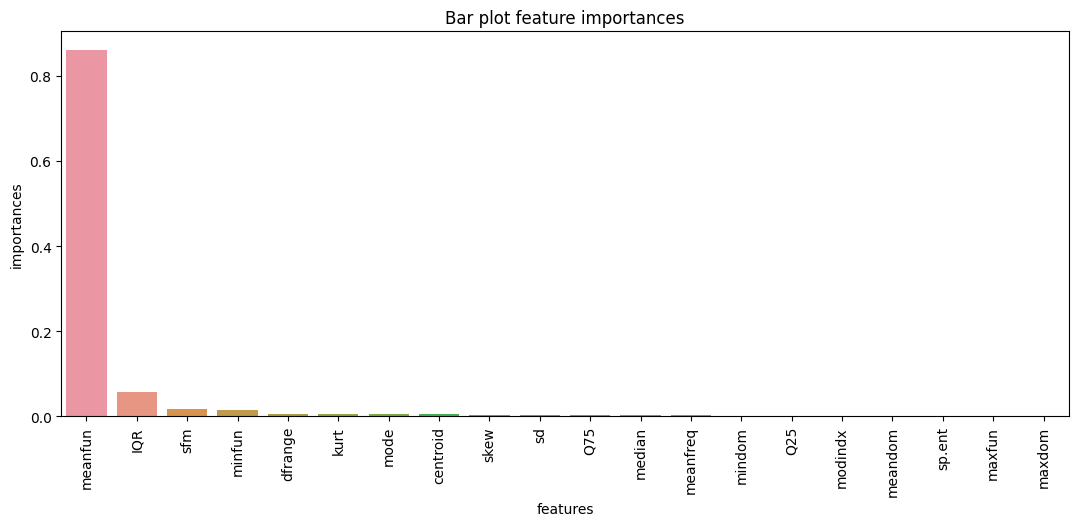

In [18]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
features = X.columns #признаки
feature_importances = best_tree.feature_importances_ #важность признаков
# Создаём DataFrame, содержащий информацию о важности признаков
importances_data = pd.DataFrame({'features': features, 'importances': feature_importances})
importances_data = importances_data.sort_values(by='importances', ascending=False)
# Строим столбчатую диаграмму
sns.barplot(data=importances_data, x='features', y='importances', ax=ax);
# Добавляем подпись к графику и поворот меток на оси абсцисс
ax.set_title('Bar plot feature importances')
ax.xaxis.set_tick_params(rotation=90)

Как видим, наша оптимизированная модель дерева решений нашла вовсе неинформативными по меньшей мере 7 факторов. Впрочем, на этот счет ее мнение может быть весьма поверхностным, и модели на других алгоритмах, веорятно, будут смотреть на те же данные чуть иначе.